<a href="https://colab.research.google.com/github/AIREheart/Computational-Neuroscience/blob/main/Tutorials/PyTorch_and_Linear_Regression_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear regression activity

The data on LEARN are measurements of the encoded response a neuron generates when a visual stimulus presented at different angles. The independent variable is the stimulus angle in radians and the dependent variable is sensory specific information in bits. The data was digitized from figure 1.B in [1].

In this activity, you will fit a regression model to this data using PyTorch. As you will see in the data plot, the curve is non-linear, so a Gaussian basis function (kernel) will be used to generate the features for the regression.

[1] D. A. Butts and M. S. Goldman, “Tuning curves, neuronal variability, and sensory coding,” PLoS Biology, vol. 4, no. 4, 2006.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle

In [2]:
!git clone https://github.com/trevor-yu-087/syde-552-w24-tutorial.git

Cloning into 'syde-552-w24-tutorial'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 43 (delta 20), reused 28 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 486.45 KiB | 2.79 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [3]:
# TODO: Change the filepath to point the regression activity data
filepath = "syde-552-w24-tutorial/tutorial/2 - regression activity data.pkl"
#####

with open(filepath, "rb") as f:
    data = pickle.load(f)

x = data["angle"]
y = data["ssi"]

print(f"x is an array of shape {x.shape}")
print(f"y is an array of shape {y.shape}")


x is an array of shape (48,)
y is an array of shape (48,)


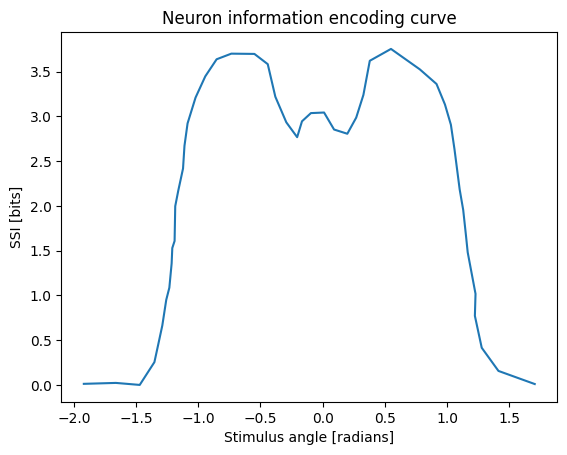

In [4]:
plt.plot(x, y)

plt.xlabel("Stimulus angle [radians]")
plt.ylabel("SSI [bits]")
plt.title("Neuron information encoding curve")
plt.show()
#we want to fit some classical functions to fit this data

In [5]:
# Convert into data torch float tensors
inputs = torch.FloatTensor(x)
targets = torch.FloatTensor(y)

In [6]:
inputs.shape, targets.shape

(torch.Size([48]), torch.Size([48]))

## Generating Gaussian kernels and broadcasting

The formula for the Gaussian function, given parameters $\mu$ and $\sigma$, is:

$$\phi(x | \mu, \sigma) = e^{-\frac{1}{2}(\frac{x - \mu}{\sigma})^2}$$

We will take a look at how to do this with broadcasting, so that we don't need to use loops to generate these features.

In [7]:
# This is incompatible with broadcasting, last dim doesn't fit rules
a = torch.ones(5)  # Shape (5,)
mu = torch.arange(3)  # Shape (3,)
a + mu
print(a)
print(mu)


RuntimeError: The size of tensor a (5) must match the size of tensor b (3) at non-singleton dimension 0

In [8]:
# This is compatible with broadcasting, last dims match
a = torch.ones((5, 3))  # Shape (5, 3)
mu = torch.arange(3)  # Shape (3,)
a + mu

tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]])

In [9]:
# This is also compatible with broadcasting, last dims of a is 1
a = torch.ones((5, 1))  # Shape (5, 1)
mu = torch.arange(3)  # Shape (3,)  maybe we don't know how many dimesnions in mu we're adding
k = a + mu
print(k.shape)
print(k.size)

torch.Size([5, 3])
<built-in method size of Tensor object at 0x7e8ce21fb890>


In [10]:
mu = torch.linspace(0, 5, 5)  # Shape (5,)
sigma = torch.ones(5)  # Shape (5,)

## Generating Gaussian kernels and broadcasting

The formula for the Gaussian function, given parameters $\mu$ and $\sigma$, is:

$$\phi(x | \mu, \sigma) = e^{-\frac{1}{2}(\frac{x - \mu}{\sigma})^2}$$

We will take a look at how to do this with broadcasting, so that we don't need to use loops to generate these features.

In [11]:
def get_gaussian_features(x, mu, sigma):
    """
    Parameters:
        x: shape (B, 1)    #assume x has 1 dim
        mu: shape (D,)
        sigma: shape (D,)

    Returns:
        phi: shape (B, D)
    """
    if x.ndim == 1:
        x = x.unsqueeze(-1)  # Shape (B, 1)
    ## TODO: Write the equation to compute the Gaussian features
    phi = torch.exp(-0.5*((x-mu)/sigma)**2)
    ###
    return phi

In [12]:
# Here, we generate 5 kernels with standard deviation of 0.5
D = 5
x = torch.linspace(-2, 2, 100) #shape is (100, 1)
mu = torch.linspace(-1.5, 1.5, D)  #shape is (5, )

std = 0.5
sigma = torch.ones(D) * std
phi = get_gaussian_features(x, mu, sigma)
print(phi.shape)

torch.Size([100, 5])


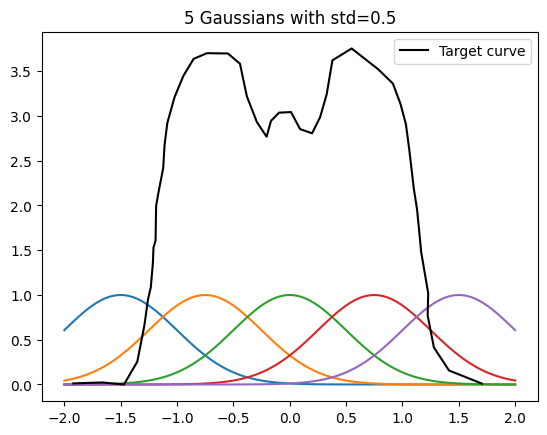

In [13]:
for i in range(D):
    plt.plot(x, phi[:, i])

plt.plot(inputs, targets, label="Target curve", c="k")
plt.title(f"{D} Gaussians with std={std}")
plt.legend()
plt.show()

Try to find a number of bases and their width that would be suitable for this problem. We ideally want to tile the input space with functions whose widths are sized appropriately to model interesting features of the target curve.

In [14]:
## TODO: Experiment with different values of D and std to find a set of kernels that spans the space well.
#we want to multiply the gaussian bumps to fit the inputted data
D = 15
std = 0.2
###

x = torch.linspace(-2, 2, 100)
mu = torch.linspace(-1.5, 1.5, D)

sigma = torch.ones(D) * std
phi = get_gaussian_features(x, mu, sigma)

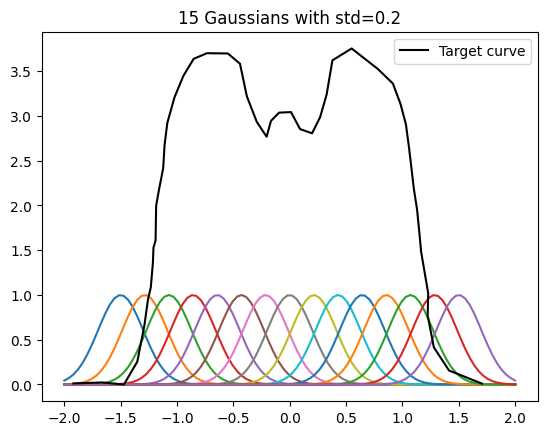

In [15]:
for i in range(D):
    plt.plot(x, phi[:, i])

plt.plot(inputs, targets, label="Target curve", c="k")
plt.title(f"{D} Gaussians with std={std}")
plt.legend()
plt.show()

## Linear regression and matrix multiplication
For linear regression, we have the following equation, where $\hat{y} \in \mathbb{R}, W \in \mathbb{R}^{D \times 1}, \vec{\phi}(x) = \mathbb{R}^{D}$.

$$\hat{y} = \sum_i^D \phi_i(x)w_i = \vec{\phi}(x) W$$

If we have a batch of $N$ targets and vectors, the equation mostly looks the same, but the shapes are different. $\hat{Y} \in \mathbb{R}^{N \times 1}, W \in \mathbb{R}^{D \times 1}, \Phi \in \mathbb{R}^{N \times D}$.

$$\hat{Y} = \Phi W$$

Note, this equation is matrix muliplication, where $\Phi$ has shape $(B, D)$ and $W$ has shape $(D, 1)$, resulting in $\hat{Y}$ of shape $(B, 1)$. The inner dimension of the two matrices match, which fits the rules for matrix multiplication.

In [16]:
# Ues mu and sigma as you found above   #in this case bc we fed in 100 pts B = 100 and phi has shape (100,D)  #here we are making matrices for Y, W weights and phi
#W and phi's D will cancel
features = get_gaussian_features(inputs, mu, sigma)

In [17]:
X = features
Y = targets.unsqueeze(-1)

X.shape, Y.shape

(torch.Size([48, 15]), torch.Size([48, 1]))

In [18]:
# Recall we set D above when we generated the Gaussians
W = torch.randn((D, 1))
W.shape

torch.Size([15, 1])

In [19]:
## TODO: Compute the model outputs, Y_hat, with matrix multiplication of lin regression, NOT looping over things and adding them
Y_hat = X@W
###
Y_hat.shape  #shape is 48,1 which is same as actual targets

torch.Size([48, 1])

## Mean squared error and reduction

The error for a single example is typically represented as:

$$E(W) = \frac{1}{2} (\hat{y} - y)^2 = \frac{1}{2} (\vec{\phi}(x) W - y)^2$$

However, we typically compute the error over a batch of examples. This equation gives a sense of how to do this operation in PyTorch, recalling the batch dimension was the first dimension of these tensors.

$$E(W) = \sum_i^B \frac{1}{2} (\vec{\phi}(x_i) W - y_i)^2 = \frac{1}{2} \sum_{\text{dim=0}} (\Phi W - Y)^{2}$$

In [20]:
# Compuate the error of this random weight matrix
#sums are reductions , dim = adding along certain dimension
Y_hat = X @ W
## TODO: Compute the error
error = 0.5* torch.sum(((Y_hat - Y)**2), dim=0)
###
error

tensor([197.9908])

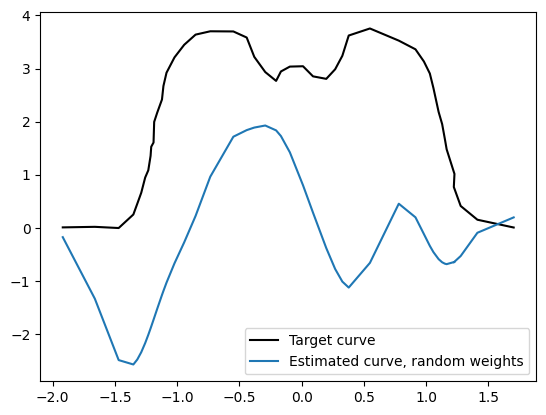

In [21]:
# Plot the regression with a random weight matrix
plt.plot(inputs, Y, label="Target curve", c="k")
plt.plot(inputs, Y_hat, label="Estimated curve, random weights")
plt.legend()
plt.show()

## Try yourself: Use equation for MLE to find optimal weights
The MLE estimator formula for optimal weight matrix, $W$ is:

$$W^{*} = (X^{\top}X)^{-1} X^{\top}Y$$

Use can use `torch.inverse(X)` to compute the matrix inverse and `X.T` to get the transpose.

Compute the optimal error and plot the outputs.

In [22]:
## TODO: Compute optimal weights with MLE formula
W_star = torch.inverse(X.T @ X) @ (X.T @ Y)
###

In [23]:
## TODO: Compute the error with optimal weights (again)
Y_hat_opt = X@W_star
error_opt = 0.5* torch.sum(((Y_hat_opt - Y)**2), dim=0)
###
error_opt

tensor([0.1430])

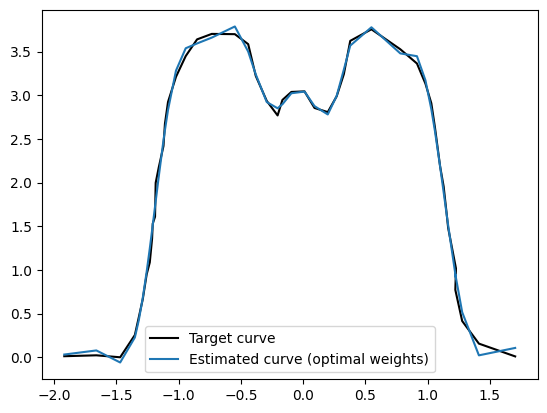

In [24]:
plt.plot(inputs, Y, label="Target curve", c="k")
plt.plot(inputs, Y_hat_opt, label="Estimated curve (optimal weights)")
plt.legend()
plt.show()